In [1]:
import torch
import gc
import os
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from time import time


os.chdir("./advanced-DL-project")

from mimo_eval import eval
#from resnet18_10 import mimo_wide_resnet18
#from resnet18_10_deter import wide_resnet18

%load_ext autoreload
%autoreload 2

gc.collect()
torch.cuda.empty_cache()

In [2]:
mimo_resnet = torch.load("/home/rebwarbajallan/mimo_resnet18_10_new_1.pt")
resnet = torch.load("/home/rebwarbajallan/resnet18_10_new_1.pt")

In [3]:
cifar10_mean = (0.4914, 0.4822, 0.4465) 
cifar10_std = (0.2470, 0.2435, 0.2616)

# Image preprocessing modules
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(cifar10_mean, cifar10_std)])

batch_size = 128

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
                                       
testloader = torch.utils.data.DataLoader(
                                    testset, 
                                    batch_size=batch_size,
                                    shuffle=False,
                                    pin_memory=True,
                                )

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [6]:
time_start = time()
resnet.eval(testloader) 
time_end = time()
print(f"Prediction time: {(time_end - time_start) / batch_size}")

Testing Accuracy: 90.8
Testing loss: 0.3112583227455616
Testing ECE: 0.050523406598949806
Prediction time: 0.09955113474279642


In [8]:
from mimo_eval import eval

time_start = time()

(
    accuracy, 
    running_loss, 
    running_ece, 
    member_accuracies,
    member_losses, 
    member_logits,
    pairwise_disagreement, pairwise_kl_diversity
) = eval(mimo_resnet, testloader)

time_end = time()
print(f"Prediction time MIMO: {(time_end - time_start) / batch_size}")


Testing Accuracy: 91.005859375
Testing loss: 0.37643555328249934
Testing ECE: 0.04065073702804511
Prediction time MIMO: 0.10688412468880415


In [78]:
print("Disagreement: ", pairwise_disagreement)
print("KL diversity: ", pairwise_kl_diversity)

Disagreement:  {'max': 0.1254, 'min': 0.0797, 'mean': 0.10310000000000002}
KL diversity:  {'max': 0.28806770524978637, 'min': 0.19558883587121964, 'mean': 0.2421001744786899}


In [43]:
stats = mimo_resnet.running_stats

member_accs = {"0": [], "1": [], "2": []}
mimo_acc = []
for epoch in stats:
    epoch_stats = stats[epoch]
    accs = epoch_stats["Testing Accuracies"]
    mimo_acc.append(epoch_stats["Testing Accuracy"])
    for ens in range(mimo_resnet.ensemble_size):
        if member_accs[f"{ens}"] is None:
            member_accs[ens] = []
        member_accs[f"{ens}"].append(accs[ens])

epochs = range(len(stats))

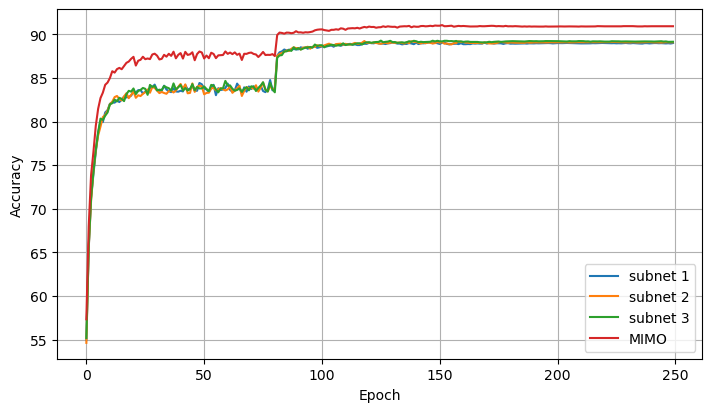

In [72]:
# Plot training accuracies as function of epochs
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
 
plt.figure(constrained_layout=True, figsize=(7, 4))
plt.style.use("default")

plt.plot(epochs, member_accs["0"], label="subnet 1")
plt.plot(epochs, member_accs["1"], label="subnet 2")
plt.plot(epochs, member_accs["2"], label="subnet 3")
plt.plot(epochs, mimo_acc, label="MIMO")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()


plt.show()

In [ ]:
import gc
  
gc.collect()
torch.cuda.empty_cache()